In [1]:
import polars as pl
import pyarrow as pa
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
df = pl.read_parquet(r'C:\Users\AG4UNA4\Downloads\HW3\Q4\parquets\batting-yearly-adv.parquet').select("id","year", "b_ba")
# df = df.filter(pl.col("id") == "gricr001")
# display(df.sort("year"))

In [ ]:
all_predictions = []

playerids = df['id'].unique()

for player_id in playerids:
    
    player_data = df.filter(pl.col('id') == player_id).to_pandas()
    

    player_data = player_data.sort_values('year')
    
    # Set  'year'  as index
    player_data.set_index('year', inplace=True)

    player_data.dropna(inplace=True)
    
    # Exclude the last year's data for model fitting
    if len(player_data) > 1:
        try:
            last_year = player_data.index[-1]
            data_for_model = player_data.iloc[:-1]
            model = ARIMA(data_for_model['b_ba'], order=(1, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1).iloc[0]
            player_data.loc[last_year, 'forecasted_b_ba'] = forecast
            
            # Forecast an additional year
            next_year = last_year + 1
            additional_forecast = model_fit.forecast(steps=2).iloc[1]
            player_data.loc[next_year] = [player_id, None, additional_forecast]
        except Exception as e:
            print(f"Error fitting ARIMA model for ID {player_id}: {e}")
    
    # Reset the index to make 'year' a column again
    player_data.reset_index(inplace=True)
    
    # Append the player's data with predictions to the list
    all_predictions.append(player_data)

# Concatenate all the player data into a single DataFrame
final_predictions_df = pd.concat(all_predictions, ignore_index=True)

# Calculate the error where both 'b_ba' and 'forecasted_b_ba' are not NaN
final_predictions_df['Error'] = final_predictions_df.apply(
    lambda row: row['b_ba'] - row['forecasted_b_ba'] if pd.notna(row['b_ba']) and pd.notna(row['forecasted_b_ba']) else None,
    axis=1
)


In [4]:
print(final_predictions_df)

       year        id      b_ba  forecasted_b_ba     Error
0      1946  johnc101  0.000000              NaN       NaN
1      1973  sharb102  0.268657              NaN       NaN
2      1974  sharb102  0.254601              NaN       NaN
3      1975  sharb102  0.254197              NaN       NaN
4      1976  sharb102  0.244444         0.254197 -0.009752
...     ...       ...       ...              ...       ...
98866  1973  manga101  0.212560              NaN       NaN
98867  1974  manga101  0.232432              NaN       NaN
98868  1975  manga101  0.220183              NaN       NaN
98869  1976  manga101  0.166667         0.228975 -0.062308
98870  1977  manga101       NaN         0.233297       NaN

[98871 rows x 5 columns]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

all_predictions = []

playerids = df['id'].unique()

for player_id in playerids:
    
    player_data = df.filter(pl.col('id') == player_id).to_pandas()
    
    player_data = player_data.sort_values('year')
    
    # Set 'year' as index
    player_data.set_index('year', inplace=True)

    player_data.dropna(inplace=True)
    
    # Exclude the last year's data for model fitting
    if len(player_data) > 1:
        try:
            last_year = player_data.index[-1]
            data_for_model = player_data.iloc[:-1]
            
            # Fit a SARIMA model
            model = SARIMAX(data_for_model['b_ba'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            model_fit = model.fit(disp=False)
            
            forecast = model_fit.forecast(steps=1).iloc[0]
            player_data.loc[last_year, 'forecasted_b_ba'] = forecast
            
            # Forecast an additional year
            next_year = last_year + 1
            additional_forecast = model_fit.forecast(steps=2).iloc[1]
            player_data.loc[next_year] = [player_id, None, additional_forecast]
        except Exception as e:
            print(f"Error fitting SARIMA model for ID {player_id}: {e}")
    
    # Reset the index to make 'year' a column again
    player_data.reset_index(inplace=True)
    
    # Append the player's data with predictions to the list
    all_predictions.append(player_data)

# Concatenate all the player data into a single DataFrame
final_predictions_sarima_df = pd.concat(all_predictions, ignore_index=True)

# Calculate the error where both 'b_ba' and 'forecasted_b_ba' are not NaN
final_predictions_sarima_df['Error'] = final_predictions_sarima_df.apply(
    lambda row: row['b_ba'] - row['forecasted_b_ba'] if pd.notna(row['b_ba']) and pd.notna(row['forecasted_b_ba']) else None,
    axis=1
)


In [6]:
print(final_predictions_sarima_df)

        year        id      b_ba  forecasted_b_ba     Error
0       2013  hamib001  0.368421              NaN       NaN
1       2014  hamib001  0.250444              NaN       NaN
2       2015  hamib001  0.225728              NaN       NaN
3       2016  hamib001  0.260341              NaN       NaN
4       2017  hamib001  0.247423              NaN       NaN
...      ...       ...       ...              ...       ...
100464  1987  esasn001  0.271676              NaN       NaN
100465  1988  esasn001  0.242967              NaN       NaN
100466  1989  esasn001  0.276596              NaN       NaN
100467  1990  esasn001  0.171429         0.276596 -0.105167
100468  1991  esasn001       NaN         0.276596       NaN

[100469 rows x 5 columns]


In [7]:
final_predictions_sarima_df.to_parquet(r'C:\Users\AG4UNA4\Downloads\HW3\Q4\parquets\final_predictions_sarima_df.parquet', index=False)
final_predictions_df.to_parquet(r'C:\Users\AG4UNA4\Downloads\HW3\Q4\parquets\final_predictions_df.parquet', index=False)

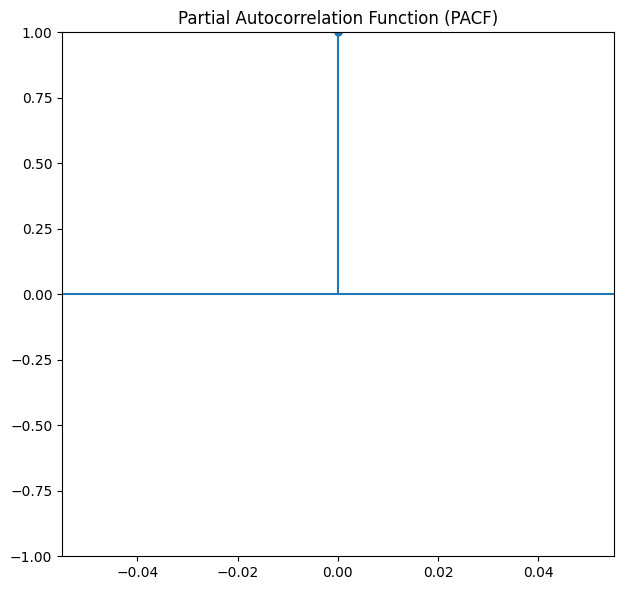

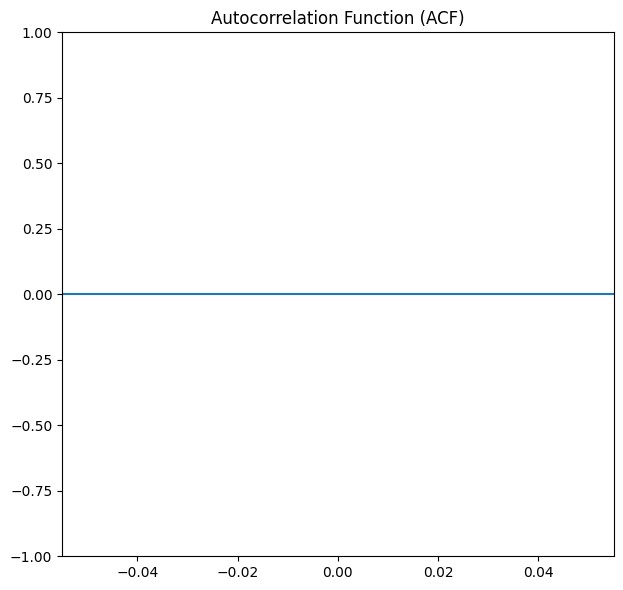

In [ ]:
def pltACF (df, lags=10):
    b_ba_series = df.to_pandas()['b_ba']
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(b_ba_series, lags=10, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')

    plt.tight_layout()
    plt.show()
    
def pltPACF (df, lags=10):
    b_ba_series = df.to_pandas()['b_ba']
    plt.figure(figsize=(12, 6))
    plt.subplot(122)
    plot_pacf(b_ba_series, lags=5, ax=plt.gca(), method='ywm')
    plt.title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()


pltPACF(df)
pltACF(df)

In [ ]:

# Set the 'year' column as the index
time_series.set_index("year", inplace=True)

# Drop rows with NaN values
time_series.dropna(inplace=True)

# Fit an ARIMA model (order can be adjusted based on the data)
model = ARIMA(time_series['b_ba'], order=(1, 1, 1))
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

# Plot the original data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Original Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values', color='red')
plt.legend()
plt.title('ARIMA Model Fit')
plt.show()
plt.show()
print('cat')


NameError: name 'time_series' is not defined